# Filtracja bilateralna


##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

In [104]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import math

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/'

fileNames = ["MR_data.mat"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)



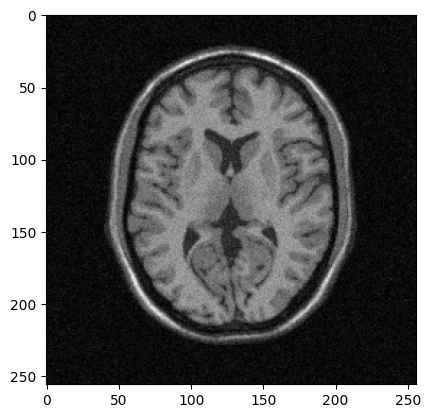

In [105]:
#TODO Samodzielna
mat = loadmat('MR_data.mat')
Input = mat['I_noisy1']

plt.imshow(Input, 'gray')

In [106]:
# Visualization of the filter

def mesh(fun, size):
    fig = plt.figure()
    ax = fig.add_subplot(projection = '3d')

    X = np.arange(-size//2, size//2, 1)
    Y = np.arange(-size//2, size//2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun

    ax.plot_surface(X, Y, Z)

    plt.show()

## Konwolucja obrazu z filtrem o zadanych współczynnikach


### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

In [107]:
# create gaussian filter

def gaussian_filter(size, var):
    filter = np.zeros((size, size), dtype=np.float32)
    center = size // 2

    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            filter[i, j] = np.exp(-(x**2 + y**2) / (2 * var ** 2))

    # Normalize the filter
    return filter / np.sum(filter)

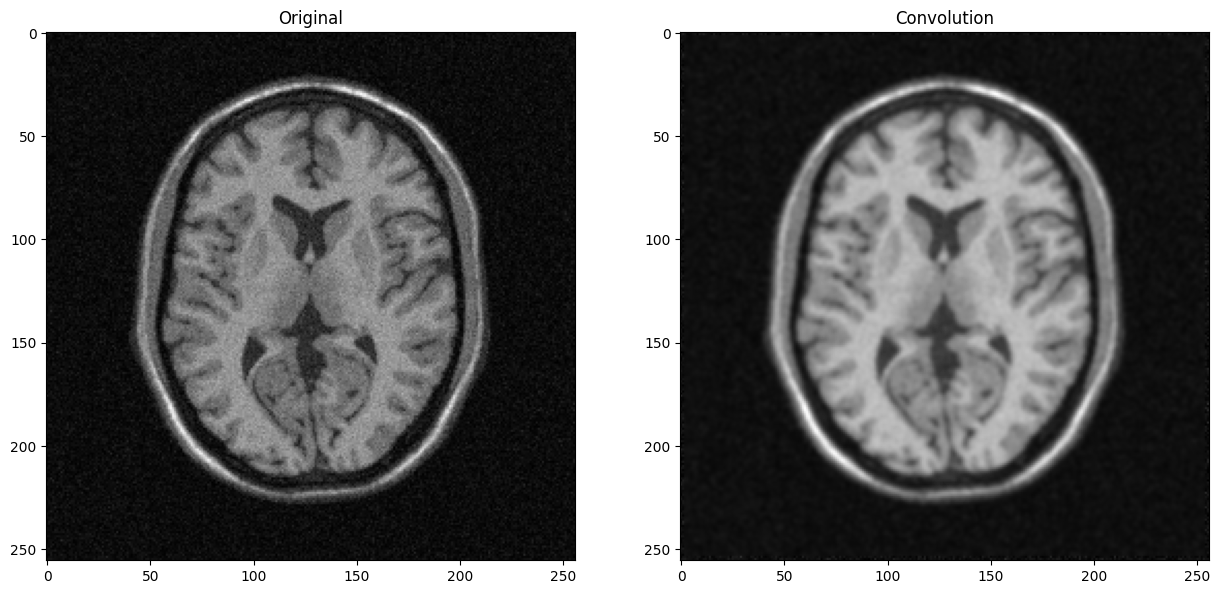

In [108]:
filter_window_size = 5
filter_var = 1

kernel = gaussian_filter(filter_window_size, filter_var)

IConv = Input.copy()

height, width = IConv.shape
offset = filter_window_size // 2

for i in range(offset, height - offset):
    for j in range(offset, width - offset):
        window = Input[i - offset: i + offset + 1, j - offset: j + offset + 1]

        IConv[i, j] = np.sum(window * kernel)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(Input, 'gray')
axs[0].set_title('Original')
axs[1].imshow(IConv, 'gray')
axs[1].set_title('Convolution')
plt.show()

### Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).


1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
2. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
3. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
4. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
5. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
1. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
2. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
3. Wykonaj normalizację obliczonych współczynników.
4.  Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
5.  Wyświetl wynik filtracji.
6.  Porównaj wynik z obrazem oryginalnym.

In [109]:
# create gaussian filter

def gaussian_filter(size, var):
    filter = np.zeros((size, size), dtype=np.float32)
    center = size // 2

    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            filter[i, j] = np.exp(-(x**2 + y**2) / (2 * var ** 2))

    # Normalize the filter
    return filter / np.sum(filter)

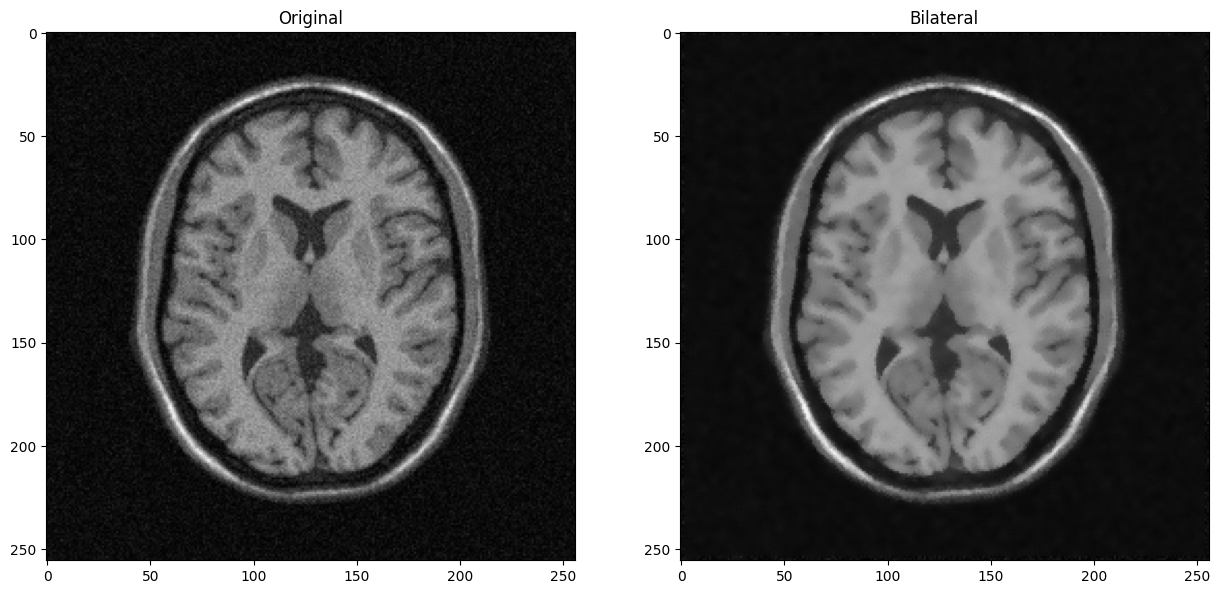

In [110]:
filter_window_size = 5
filter_var = 10
var_r = 25  # wyznacz empirycznie

kernel = gaussian_filter(filter_window_size, filter_var)

IBilateral = Input.copy()

height, width = Input.shape
offset = filter_window_size // 2

for i in range(offset, height - offset):
    for j in range(offset, width - offset):
        window = Input[i - offset: i + offset + 1, j - offset: j + offset + 1]

        # add intesity factor to kernel
        intensity_diff = window - window[offset, offset]
        I_kernel = np.exp((- intensity_diff**2) / (2 * var_r ** 2))
        combined_kernel = I_kernel * kernel
        combined_kernel = combined_kernel / np.sum(combined_kernel)

        IBilateral[i, j] = np.sum(window * combined_kernel)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(Input, 'gray')
axs[0].set_title('Original')
axs[1].imshow(IBilateral, 'gray')
axs[1].set_title('Bilateral')
plt.show()